In [69]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib
import math

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [4]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 20
fictrac_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [5]:
fly_dir = os.path.join(dataset_path, fly_names[0], 'func_0')
fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
neural_timestamps_all_slice = bbb.load_timestamps(os.path.join(fly_dir, 'imaging'))


~~ load_fictrac ~~
load_fictrac done. Duration: 1.91 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 4.53 ms


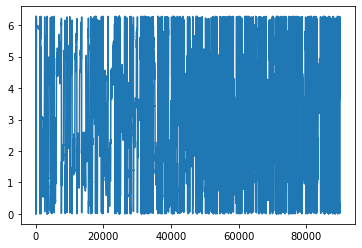

In [59]:
plt.plot(np.asarray(fictrac_raw['heading']))

In [64]:
fwd = scipy.signal.savgol_filter(np.asarray(fictrac_raw['dRotLabY']),25,3)
heading = scipy.signal.savgol_filter(np.asarray(fictrac_raw['heading']),25,3)

In [7]:
xpos = scipy.signal.savgol_filter(np.asarray(fictrac_raw['positionX']),25,3)
ypos = scipy.signal.savgol_filter(np.asarray(fictrac_raw['positionY']),25,3)

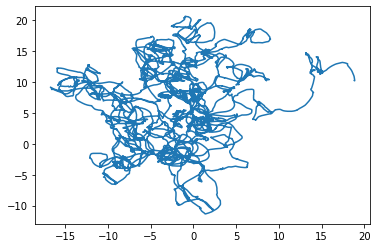

In [8]:
plt.plot(xpos,ypos)

In [150]:
cluster = 150#77#174#77
neural = supercluster_signals[cluster,:3384]

In [ ]:
cluster = 150#77#174#77
neural = supercluster_signals[cluster,:3384]


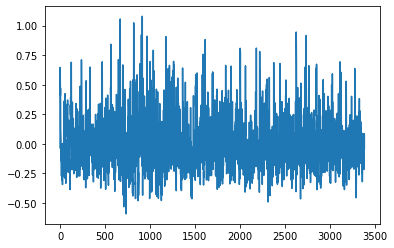

In [151]:
plt.plot(neural)

In [152]:
z = 20 ### improve code to correcly get this
neural_timestamps = neural_timestamps_all_slice[:,z]

In [153]:
interp_object = interp1d(neural_timestamps, neural, bounds_error = False)
neural_highres = interp_object(fictrac_timepoints)
np.nan_to_num(neural_highres, copy=False);

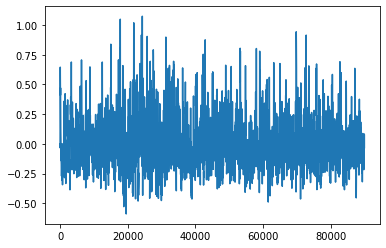

In [154]:
plt.plot(neural_highres)
#plt.plot(fwd*10)

(50000, 57000)

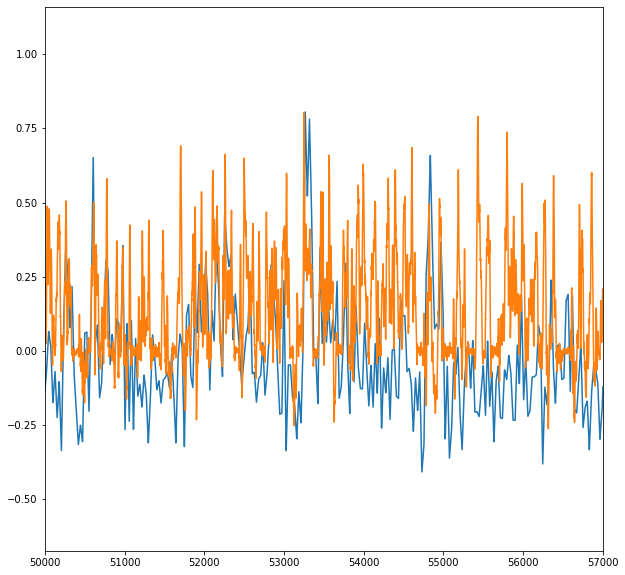

In [155]:
plt.figure(figsize=(10,10))
plt.plot(neural_highres)
plt.plot(fwd*10)
plt.xlim(50000,57000)

(0, 10000)

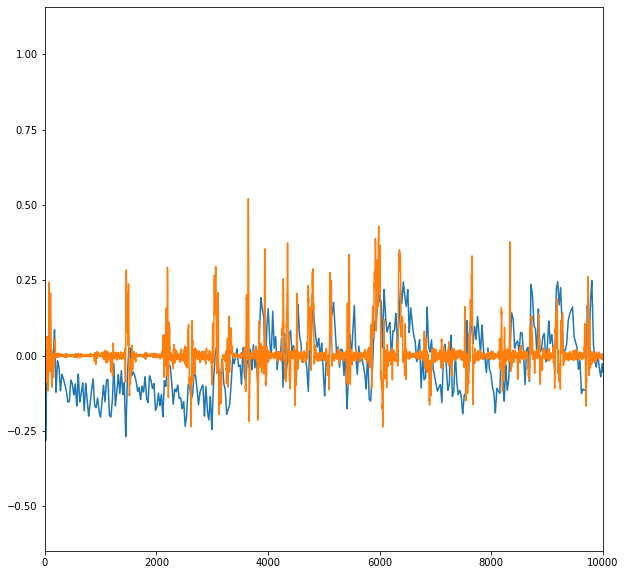

In [15]:
plt.figure(figsize=(10,10))
plt.plot(neural_highres)
plt.plot(fwd*10)
plt.xlim(0,10000)

In [156]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
cmap = matplotlib.cm.get_cmap('seismic')

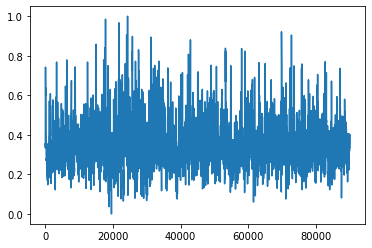

In [157]:
neural_highres_norm = NormalizeData(neural_highres)
plt.plot(neural_highres_norm)

75


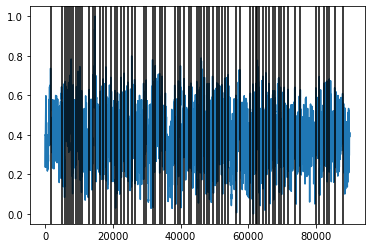

In [199]:
cluster = 327#77#174#77
neural = supercluster_signals[cluster,:3384]
interp_object = interp1d(neural_timestamps, neural, bounds_error = False)
neural_highres = interp_object(fictrac_timepoints)
np.nan_to_num(neural_highres, copy=False);
neural_highres_norm = NormalizeData(neural_highres)

peaks = scipy.signal.find_peaks(neural_highres_norm,height=0.6,distance=500)[0]
print(len(peaks))
plt.plot(neural_highres_norm)
for peak in peaks:
    plt.axvline(peak,color='k')

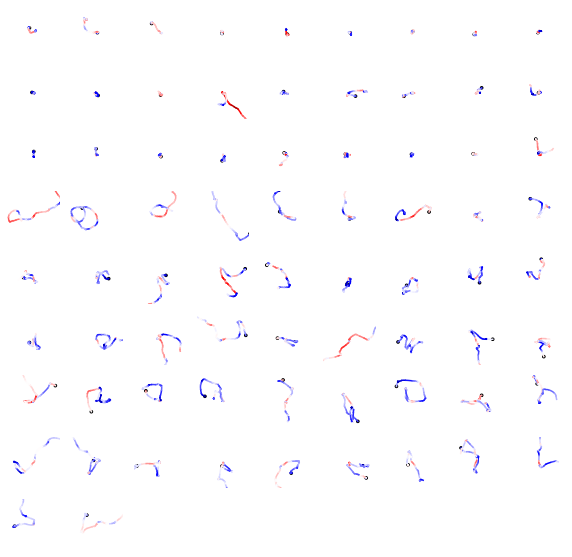

In [200]:
plt.figure(figsize=(10,10))
n_row = int(np.ceil(len(peaks)**0.5))

window = 300
for j,peak in enumerate(peaks[1:]):
    plt.subplot(n_row,n_row,j+1)
    plt.axis('off')
    circle = plt.Circle((xpos[peak-window]-xpos[peak], ypos[peak-window]-ypos[peak]), 0.2, color='k')
    ax = plt.gca()
    ax.add_patch(circle)
    for i in np.arange(peak-window,peak+window,10):
        color = np.mean(neural_highres_norm[i:i+10])
        plt.plot(xpos[i:i+10]-xpos[peak],ypos[i:i+10]-ypos[peak],color=cmap(color))
    lim = 4
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)

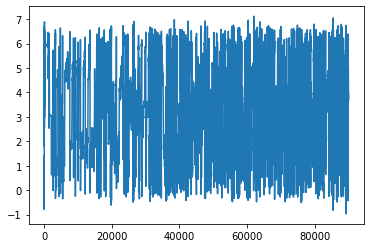

In [71]:
plt.plot(heading)

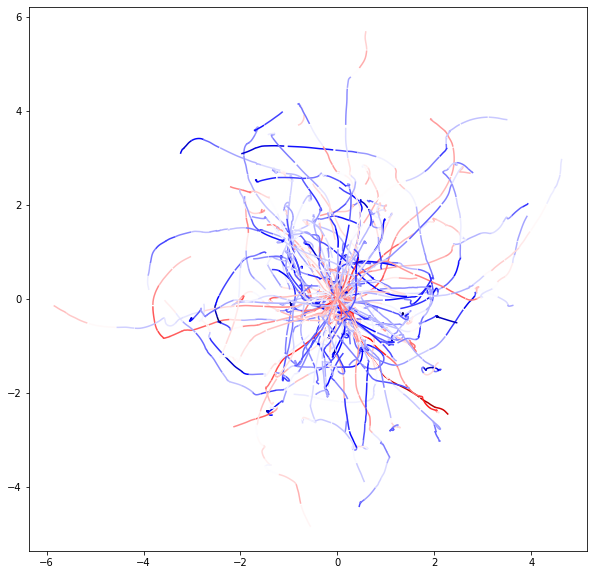

In [201]:
plt.figure(figsize=(10,10))
window = 200
for peak in peaks[1:]:
    theta = heading[peak]
    r = np.array(( (np.cos(theta), -np.sin(theta)), (np.sin(theta),  np.cos(theta)) ))
    xpos_bout = xpos[peak-window:peak+window]
    ypos_bout = ypos[peak-window:peak+window]
    for j,i in zip(np.arange(0,window*2,10), np.arange(-window,window,10)):
        color = np.mean(neural_highres_norm[peak+i:peak+i+10])
        plt.plot(xpos_bout[j:j+10]-xpos[peak],ypos_bout[j:j+10]-ypos[peak],color=cmap(color))

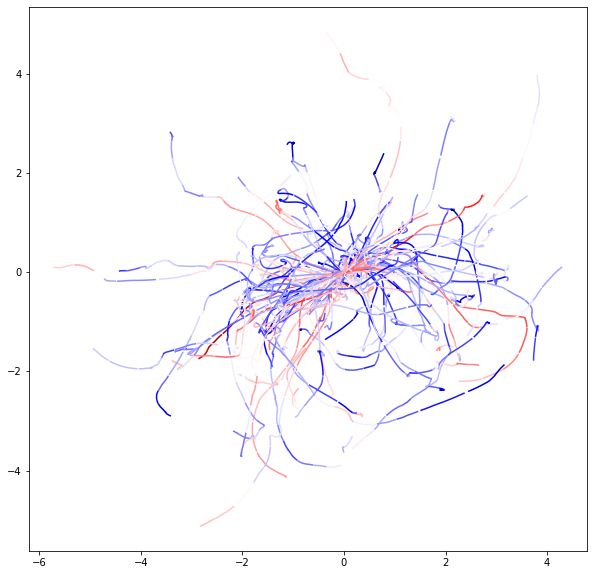

In [202]:
plt.figure(figsize=(10,10))
window = 200
for peak in peaks[1:]:
    theta = -heading[peak]
    r = np.array(( (np.cos(theta), -np.sin(theta)), (np.sin(theta),  np.cos(theta)) ))
    xpos_bout = xpos[peak-window:peak+window]-xpos[peak]
    ypos_bout = ypos[peak-window:peak+window]-ypos[peak]
    p = np.concatenate((xpos_bout[:,np.newaxis],ypos_bout[:,np.newaxis]),axis=1)
    out = np.dot(r,p.T)
    xpos_rot = out[0,:]
    ypos_rot = out[1,:]
    
    for j,i in zip(np.arange(0,window*2,10), np.arange(-window,window,10)):
        color = np.mean(neural_highres_norm[peak+i:peak+i+10])
        plt.plot(xpos_rot[j:j+10],ypos_rot[j:j+10],color=cmap(color))

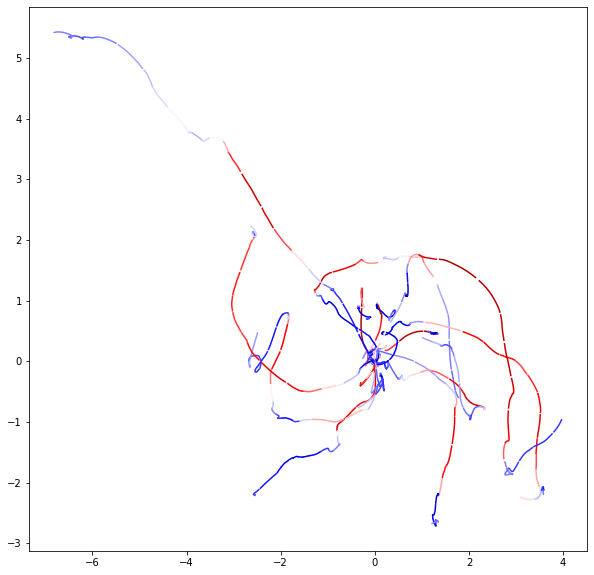

In [160]:
plt.figure(figsize=(10,10))
window = 200
for peak in peaks[1:]:
    for i in np.arange(peak-window,peak+window,10):
        color = np.mean(neural_highres_norm[i:i+10])
        plt.plot(xpos[i:i+10]-xpos[peak-window],ypos[i:i+10]-ypos[peak-window],color=cmap(color))

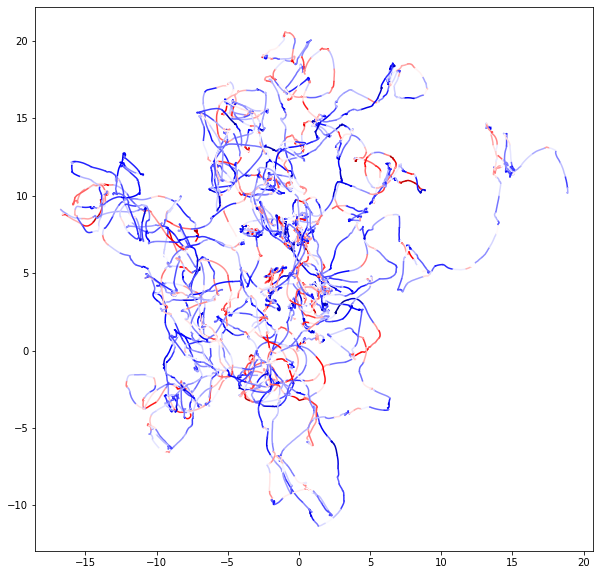

In [24]:
plt.figure(figsize=(10,10))
for i in np.arange(0,len(xpos)-1,20):
    color = np.mean(neural_highres_norm[i:i+20])
    plt.plot(xpos[i:i+20],ypos[i:i+20],color=cmap(color))

In [206]:
77+250

327

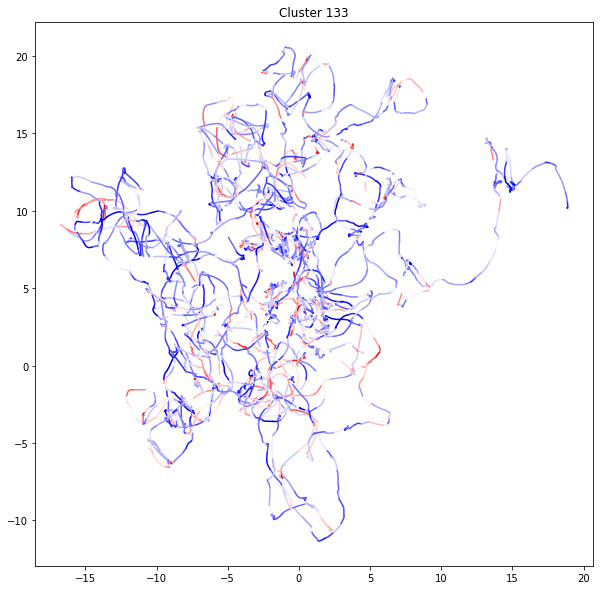

In [208]:
cluster = 133#77#174#77
neural = supercluster_signals[cluster,:3384]
interp_object = interp1d(neural_timestamps, neural, bounds_error = False)
neural_highres = interp_object(fictrac_timepoints)
np.nan_to_num(neural_highres, copy=False);
neural_highres_norm = NormalizeData(neural_highres)

plt.figure(figsize=(10,10))
jump = 20
for i in np.arange(0,len(xpos)-1,jump):
    color = np.mean(neural_highres_norm[i:i+jump])
    plt.plot(xpos[i:i+jump],ypos[i:i+jump],color=cmap(color))
    plt.title(F"Cluster {cluster}")